In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import csv
import cv2
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
tf.python.control_flow_ops = tf

Using TensorFlow backend.


In [2]:

def drift_right(random_row):
    X_train, y = X_train, str(float(y) + offset)
    X_train = X_train.strip()
    img= cv2.imread('simulator/data/'+ X_train)
    rows,cols = 160,320
    M = np.float32([[1,0,80],[0,1,30]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    rgb_dst = preProcessed_img(dst)
    return rgb_dst, y

def randomize_angle(angle):
#     if str(angle) == '0':
    ran_angle = float(angle) * (1.00000 + np.random.uniform(-1, 1)/30.000)
#     ran_angle = float(angle)
    return ran_angle

def img_augmentation(random_row):
    prob_camera = np.random.uniform(low= 0.00, high = 1.00)
    camera_type = None
    offset = None
    prob_state = None

    if random_row['steering'] == '0':
        prob_state = np.random.randint(low= 1, high = 10.00) % 2
        #31
    if 0.31 > prob_camera:
        camera_type = 'left'
        offset = 2.00000
    elif 0.62 > prob_camera >= 0.31:
        camera_type = 'right'
        offset = -1 * 2.00000
    else:
        camera_type = 'center'
        offset = 0

    prob_drift = np.random.uniform(low= 0.00, high = 1.00)
    drift_type = None
    prob_index =  np.random.uniform(low= 0.00, high = 1.00)
    #31
    if prob_drift < 0.32:
        drift_type = np.float32([[1,0, 80],[0,1,30]])#drift right np.float32([[1,0,80],[0,1,30]])
        offset = offset - 2.2000 #offset = offset - 2.10000
    elif 0.64 > prob_drift >= 0.32:
        drift_type = np.float32([[1,0, -80],[0,1,30]]) #drift left np.float32([[1,0,-80],[0,1,30]]) 
        offset = offset + 2.2000
    else:
        drift_type = np.float32([[1,0,0],[0,1,0]]) #center
        offset = offset
    
    random_angle = randomize_angle(random_row['steering']) 
    X, y = random_row[camera_type], str(random_angle + offset)
    X = X.strip()
    img= cv2.imread('simulator/data/'+ X)
    rows,cols = 160,320
    dst = cv2.warpAffine(img, drift_type,(cols,rows))
    rgb_resized_img = preProcessed_img(dst)
    flip_chance = np.random.uniform(low=0.00, high = 1.00)
    if flip_chance > 0.35: #33
        rgb_resized_img = cv2.flip(rgb_resized_img, 1)  
        y = str(-1 * float(y))
    return rgb_resized_img, y

In [3]:
import random
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sys

%matplotlib inline
BATCH_SIZE = 20
# TOTAL = 8037
TOTAL = 16074
OFFSET = 2.200
steering_arr = []
imgsPath_arr = []

f = open('simulator/data/driving_log.csv')
    
dictReader = csv.DictReader(f)
log_arr = []
classDict = {}
for row in dictReader:
    log_arr.append(row)
f.close()
    
X_train, X_validation_test = train_test_split(log_arr, test_size = 0.3, random_state = 0)
X_validation, X_test = train_test_split(X_validation_test, test_size = 0.33, random_state = 0)

def generate_imgs_path(path):
    f = open(path)
    reader = csv.DictReader(f)
    for row in reader:
        imgsPath_arr.append(row['center'])
    
    return imgsPath_arr

#evaluation model to see the model accuracy rate
def evaluate(X_data, BATCH_SIZE):
    imgArr = np.zeros((BATCH_SIZE, 66, 200, 3), dtype=np.float32) #66, 200
    labelsArr = np.zeros(BATCH_SIZE, dtype=np.float32)
    while 1:
        for counter in range(0, BATCH_SIZE):
            random_row = random.choice(X_data)
            x, y = random_row['center'], random_row['steering']
            x = x.strip()
            img = cv2.imread('simulator/data/'+ x)
            resized_img = preProcessed_img(img)
            imgArr[counter] = resized_img
            labelsArr[counter] = y
        yield (imgArr, labelsArr)

def preprocessed_flip(resized_img):
    flip_img = resized_img.copy()
    flip_img = cv2.flip(resized_img, 1)   
    return flip_img

def preprocess_left_offset(random_row):
    X_left, y_left = random_row['right'], str(float(random_row['steering']) - offset)
    X_left = X_left.strip()
    img_left = cv2.imread('simulator/data/'+ X_left)
    resized_img_left = preProcessed_img(img_left)
    return resized_img_left, y_left

def preprocess_right_offset(random_row):
    X_right, y_right = random_row['left'], str(float(random_row['steering']) + offset)
    X_right = X_right.strip()
    img_right = cv2.imread('simulator/data/'+ X_right)
    resized_img_right = preProcessed_img(img_right)
    return resized_img_right, y_right  

def preprocess_right_camera_offset(random_row):
    X_center_right, y_center_right = random_row['right'], str(float(random_row['steering']) - offset)
    X_center_right = X_center_right.strip()
    img_center_right = cv2.imread('simulator/data/'+ X_center_right)
    resized_img_center_right = preProcessed_img(img_center_right)
    return resized_img_center_right, y_center_right

def preprocess_left_camera_offset(random_row):
    X_center_left, y_center_left = random_row['left'], str(float(random_row['steering']) + offset)
    X_center_left = X_center_left.strip()
    img_center_left = cv2.imread('simulator/data/'+ X_center_left)
    resized_img_center_left = preProcessed_img(img_center_left)
    return resized_img_center_left, y_center_left

def preProcessed_img(img):
    img = img[135//5: 135, 0:320]
    chance = np.random.uniform(low=0.00, high=1.00)
    if chance > 0.8:
        brightness_img_copy = img.copy()
        random_val = np.random.uniform() + 0.25
        birghtness_img_hsv = cv2.cvtColor(brightness_img_copy, cv2.COLOR_BGR2HSV)
        birghtness_img_hsv[:,:, 2] = birghtness_img_hsv[:,:, 2] * random_val
        bgr_img =  cv2.cvtColor(birghtness_img_hsv, cv2.COLOR_HSV2RGB)
        yuv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YUV)
        resized_img = cv2.resize(yuv_img, (200, 66)) #(200,66)
        return resized_img
    else:
        yuv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        resized_img = cv2.resize(yuv_img, (200, 66))
        return resized_img
     
def generate_imgs_from_file(X_train, file_path):

    centerArr = []
    steeringArr = []

    f = open(file_path)

    while 1:

        img_arr = np.zeros((BATCH_SIZE, 66, 200, 3)) #66, 200
        steering_arr = np.zeros(BATCH_SIZE)
        try:
            for counter in range(BATCH_SIZE):
                random_row = random.choice(X_train)
#                 x, y= random_row['center'], random_row['steering']
#                 x = x.strip()
#                 print(x)
                randomChance = np.random.uniform(low=0.00, high=1.00)
                chance = np.random.uniform(low= 0.00, high = 1.00)

                img_arr[counter], steering_arr[counter] = img_augmentation(random_row)
#                 if chance >= 0.86:
#                     chance = np.random.uniform(low= 0.00, high = 1.00)                
#                     img = cv2.imread('simulator/data/'+ x)
#                     resized_img = preProcessed_img(img)
#                     img_arr[counter] = resized_img
#                     steering_arr[counter] =  y                
#         #             elif 0.6 > randomChance >= 0.3:
#                 if 0.86 > chance >= 0.43:
# #                 if float(y) < 0.05:
#                         #right camera
#                     img_arr[counter], steering_arr[counter] =  preprocess_right_camera_offset(random_row)

#         #             elif 0.9 > randomChance >= 0.6:
#                 if chance < 0.43:
#                         #left camera
#                     img_arr[counter], steering_arr[counter] =  preprocess_left_camera_offset(random_row)

            yield (img_arr, steering_arr)
        except TypeError:
#             print("TypeErrorr", x)
            break
        
                            

    f.close()

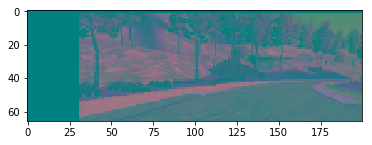

In [ ]:
#testing purpose
def drift_left():
    X, y = 'IMG/center_2016_12_01_13_37_17_074.jpg', '2.2'
    X = X.strip()
    img= cv2.imread('simulator/data/'+ X)
    rows,cols = 160,320
    M = np.float32([[1,0,50],[0,1,30]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    rgb_dst = preProcessed_img(dst)

    plt.imshow(rgb_dst)

drift_left()


In [ ]:
import keras
from keras.layers.core import Lambda
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2
import numpy as np


def nvidia_model():
    """
    NVIDIA model
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(66, 200, 3)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", activation="elu", W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", activation="elu", W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", activation="elu", W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode="valid", subsample=(1, 1),activation="elu", W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode="valid", subsample=(1, 1), activation="elu", W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation="elu"))
    model.add(Dense(50, activation="elu"))
    model.add(Dense(10, activation="elu"))
    model.add(Dense(1, activation="tanh"))
    model.add(Dropout(0.5))
    return model

def commaAI_model():
    """
    Comma.ai model
    """
    ch, row, col = 3, 66, 200  # camera format #66 , 200

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation="elu", W_regularizer=l2(0.001)))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation="elu", W_regularizer=l2(0.001)))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation="elu", W_regularizer=l2(0.001)))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Dense(512, activation="elu", W_regularizer=l2(0.001)))
    model.add(Dropout(.5))
    model.add(Dense(1, activation="elu", W_regularizer=l2(0.001)))
    model.compile(optimizer="adam", loss="mse")

    return model
model = commaAI_model()
# model = nvidia_model()
# model = load_model('model.json')
# model.load_weights('best_model.h5')
keras.optimizers.Adam(lr= 0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = 'adam', loss='mse')
checkpointer = ModelCheckpoint(filepath="checkpoints/weights.hdf5", verbose=1, save_best_only=True)
model.fit_generator(generate_imgs_from_file(X_train,'simulator/data/driving_log.csv'), validation_data = evaluate(X_train, BATCH_SIZE), samples_per_epoch= 2060, nb_val_samples= 200, nb_epoch= 10, verbose=1, callbacks=[checkpointer])


Epoch 1/10
1040/2060 [==============>...............] - ETA: 10s - loss: 4.4185 

In [ ]:
from keras.models import model_from_json

def save_model_weighs(model_file, weights_file):
    model_JSON = model.to_json()
    with open(model_file, "w") as json:
        json.write(model_JSON)
    model.save_weights(weights_file)
    print("Model and weights saved sucessfully!")

save_model_weighs("simulator/model.json", "simulator/model.h5")

    